# Load packages
First, we need to load the relevant packages, `scanpy` to handle scRNA-seq data and `decoupler` to use statistical methods.

In [18]:
import scanpy as sc
import decoupler as dc

# Plotting options, change to your liking
sc.settings.set_figure_params(dpi=720, frameon=False)
sc.set_figure_params(dpi=720)
sc.set_figure_params(figsize=(8, 8))

# load the data

- We can load the data via `scanpy`

In [2]:
adata = sc.read_h5ad('./GSE184880_HGSCO_annoed.h5ad')
adata

/Users/jialechen/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'group_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'scaled|original|X_pca'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'lognorm', 'scaled'
    obsp: 'connectivities', 'distances'

/Users/jialechen/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


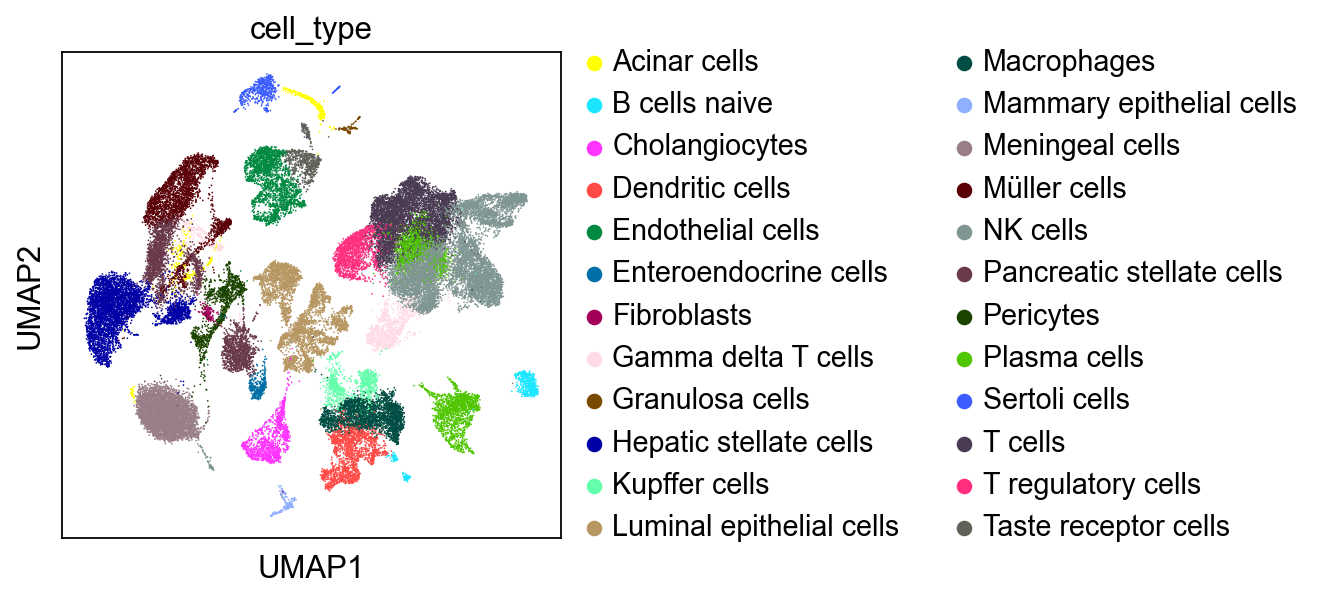

In [3]:
# We can visualize the different cell types in it:
sc.pl.umap(adata, color='cell_type')

In [4]:
adata.obs['cell_type'].value_counts()


NK cells                     7979
T cells                      5254
Meningeal cells              4798
Hepatic stellate cells       4422
Luminal epithelial cells     3830
Pancreatic stellate cells    3311
Plasma cells                 3190
Müller cells                 2856
Macrophages                  2543
Endothelial cells            2125
Dendritic cells              1775
T regulatory cells           1535
Gamma delta T cells          1189
Pericytes                    1189
Cholangiocytes               1141
Kupffer cells                 944
Taste receptor cells          726
B cells naive                 596
Sertoli cells                 580
Acinar cells                  483
Enteroendocrine cells         338
Mammary epithelial cells      179
Fibroblasts                   130
Granulosa cells               102
Name: cell_type, dtype: int64

# PROGENy model
PROGENy is a comprehensive resource containing a curated collection of pathways and their target genes, with weights for each interaction. For this example we will use the human weights (other organisms are available) and we will use the top 500 responsive genes ranked by p-value. Here is a brief description of each pathway:

- Androgen: involved in the growth and development of the male reproductive organs.

- EGFR: regulates growth, survival, migration, apoptosis, proliferation, and differentiation in mammalian cells

- Estrogen: promotes the growth and development of the female reproductive organs.

- Hypoxia: promotes angiogenesis and metabolic reprogramming when O2 levels are low.

- JAK-STAT: involved in immunity, cell division, cell death, and tumor formation.

- MAPK: integrates external signals and promotes cell growth and proliferation.

- NFkB: regulates immune response, cytokine production and cell survival.

- p53: regulates cell cycle, apoptosis, DNA repair and tumor suppression.

- PI3K: promotes growth and proliferation.

- TGFb: involved in development, homeostasis, and repair of most tissues.

- TNFa: mediates haematopoiesis, immune surveillance, tumour regression and protection from infection.

- Trail: induces apoptosis.

- VEGF: mediates angiogenesis, vascular permeability, and cell migration.

- WNT: regulates organ morphogenesis during development and tissue repair.


In [5]:
progeny = dc.get_progeny(organism='human', top=500)
progeny

0.00B [00:00, ?B/s]

,source,target,weight,p_value
0,Androgen,TMPRSS2,11.490631,0.000000e+00
1,Androgen,NKX3-1,10.622551,2.242078e-44
2,Androgen,MBOAT2,10.472733,4.624285e-44
3,Androgen,KLK2,10.176186,1.944414e-40
4,Androgen,SARG,11.386852,2.790209e-40
...,...,...,...,...
6995,p53,ZMYM4,-2.325752,1.522388e-06
6996,p53,CFDP1,-1.628168,1.526045e-06
6997,p53,VPS37D,2.309503,1.537098e-06
6998,p53,TEDC1,-2.274823,1.547037e-06


To run `decoupler` methods, we need an input matrix (`mat`), an input prior knowledge network/resource (`net`), and the name of the columns of `net` that we want to use.



In [7]:
dc.run_mlm(
    mat=adata,
    net=progeny,
    source='source',
    target='target',
    weight='weight',
    verbose=True,
    use_raw=False
)

Running mlm on mat with 51215 samples and 3533 targets for 14 sources.


The obtained scores (t-values)(`mlm_estimate`) and p-values (`mlm_pvals`) are stored in the `.obsm` key:

In [8]:
adata.obsm['mlm_estimate']

,Androgen,EGFR,Estrogen,Hypoxia,JAK-STAT,MAPK,NFkB,PI3K,TGFb,TNFa,Trail,VEGF,WNT,p53
AAACCCAAGGACAGCT-1,-0.813837,-0.483607,0.616998,-0.234471,-2.718103,-0.232167,0.605251,0.339120,0.802936,-1.114542,-0.677032,-0.042215,-0.213732,0.479669
AAACCCAAGGTATCTC-1,0.225453,-1.986488,2.312968,-1.142229,-2.353225,0.200999,-0.376951,-0.193815,1.824299,-0.300116,0.219382,0.476886,-0.557014,-1.119322
AAACCCACAAGTGCAG-1,0.591442,0.163131,1.325234,-1.540993,-0.661697,-0.876360,-0.565886,-2.516302,0.594144,0.141748,-0.968670,-1.779909,0.650338,-0.114435
AAACCCACACCCTCTA-1,-0.444647,-0.366920,0.235019,-0.334037,-2.508098,-0.941954,-0.516723,-0.335305,0.490986,-0.178456,-0.920964,0.184561,-0.625211,-0.976044
AAACCCACACTCCGGA-1,-0.516017,-2.993864,1.816712,1.045636,-2.407442,2.102218,-0.835334,-0.461943,0.522202,-0.043973,0.180738,-1.235058,0.332010,0.385539
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TTTGGTTAGTTGGCTT-1,-0.144695,-1.840157,-0.360974,-1.776863,8.674528,1.054220,-0.737298,0.942692,0.199402,0.204912,-0.760610,-0.786586,-1.043422,-0.381382
TTTGGTTGTTCCTACC-1,-0.970558,-1.622554,0.259298,2.497685,0.047780,2.837093,-1.552737,0.250340,-2.885724,0.505493,-0.772664,-1.308686,-1.523534,-8.794136
TTTGGTTGTTTCGCTC-1,-0.327296,0.634140,-0.354888,-3.325879,12.082528,1.960387,1.862961,0.245777,-2.493480,-1.560545,-0.495465,-0.326068,0.068841,-9.667027
TTTGGTTTCCACAAGT-1,-0.622901,-0.979417,-1.619816,-0.785556,0.240340,1.819616,-0.947201,0.651937,-0.640818,0.360707,0.790470,0.909737,-0.918539,0.676189


In [9]:
adata.obsm['progeny_mlm_estimate'] = adata.obsm['mlm_estimate'].copy()
adata.obsm['progeny_mlm_pvals'] = adata.obsm['mlm_pvals'].copy()
adata

AnnData object with n_obs × n_vars = 51215 × 3533
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'mean', 'std'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'group_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'scaled|original|X_pca', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'
    varm: 'PCs', 'scaled|original|pca_loadings'
    layers: 'lognorm', 'scaled'
    obsp: 'connectivities', 'distances'

# Visualization

To visualize the obtained scores, we can re-use many of `scanpy`’s plotting functions. First though, we need to extract the activities from the `adata` object.

In [10]:
acts = dc.get_acts(adata, obsm_key='mlm_estimate')
acts

/Users/jialechen/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/Users/jialechen/anaconda3/lib/python3.11/site-packages/anndata/_core/anndata.py:1897: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 51215 × 14
    obs: 'sample', 'group', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'leiden', 'cell_type'
    uns: 'cell_type_colors', 'dendrogram_leiden', 'group_colors', 'hvg', 'leiden', 'leiden_colors', 'log1p', 'neighbors', 'pca', 'scaled|original|cum_sum_eigenvalues', 'scaled|original|pca_var_ratios', 'umap'
    obsm: 'X_pca', 'X_umap', 'ora_estimate', 'ora_pvals', 'scaled|original|X_pca', 'mlm_estimate', 'mlm_pvals', 'progeny_mlm_estimate', 'progeny_mlm_pvals'

`dc.get_acts` returns a new `AnnData` object which holds the obtained activities in its .X attribute, allowing us to re-use many `scanpy` functions, for example let’s visualise the Trail pathway:

/Users/jialechen/anaconda3/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


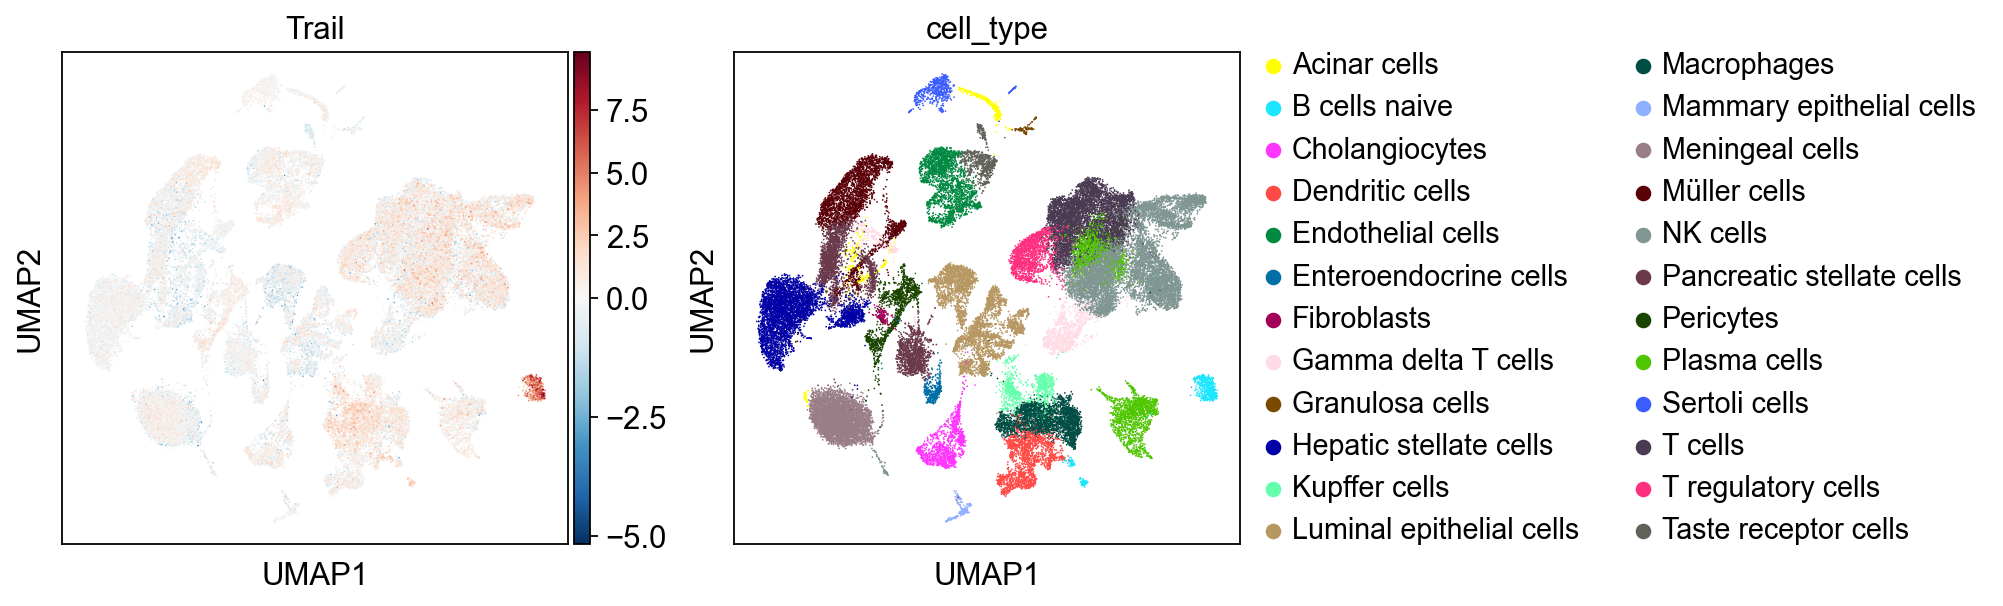

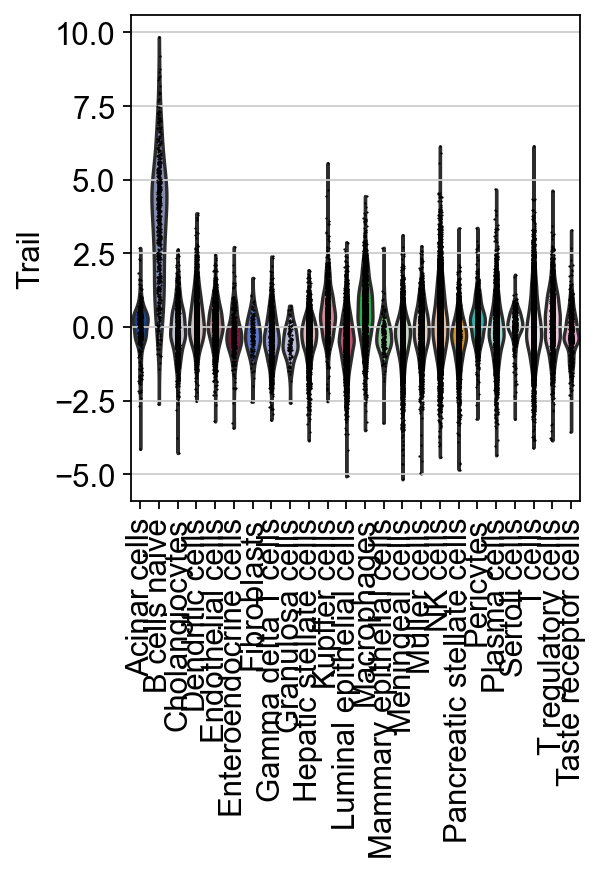

In [13]:
sc.pl.umap(acts, color=['Trail', 'cell_type'], cmap='RdBu_r', vcenter=0)
sc.pl.violin(acts, keys=['Trail'], groupby='cell_type', rotation=90)

# Exploration
We can visualize which pathways are more active in each cell type:

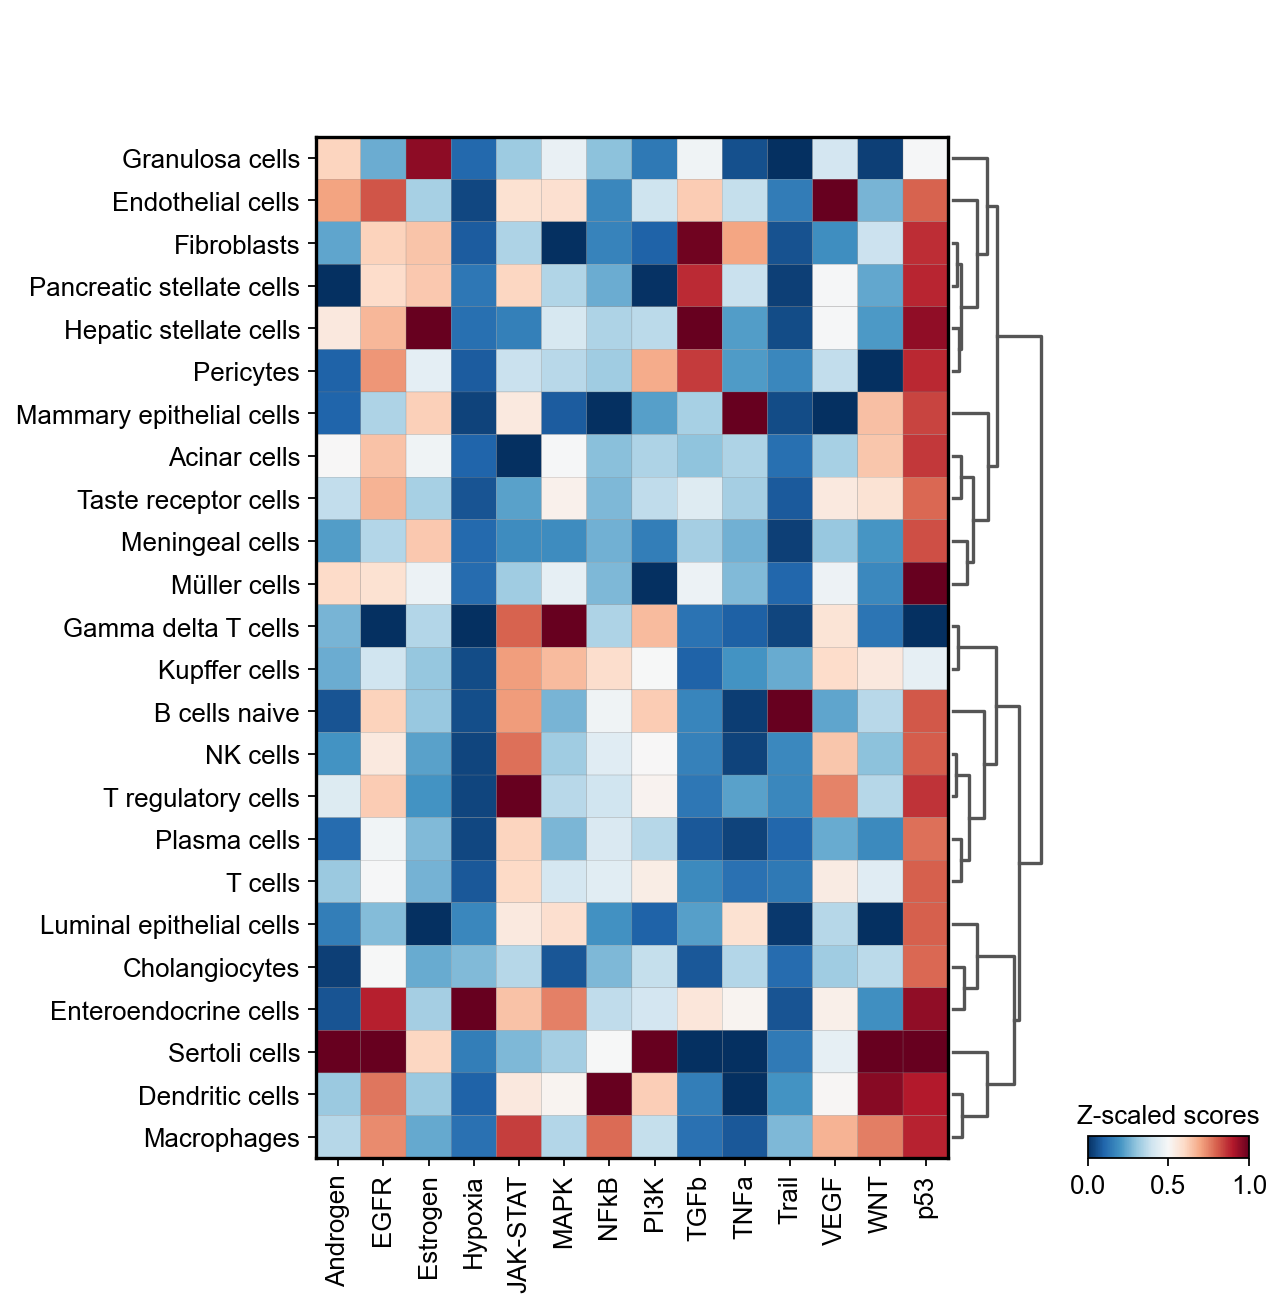

In [14]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='cell_type', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

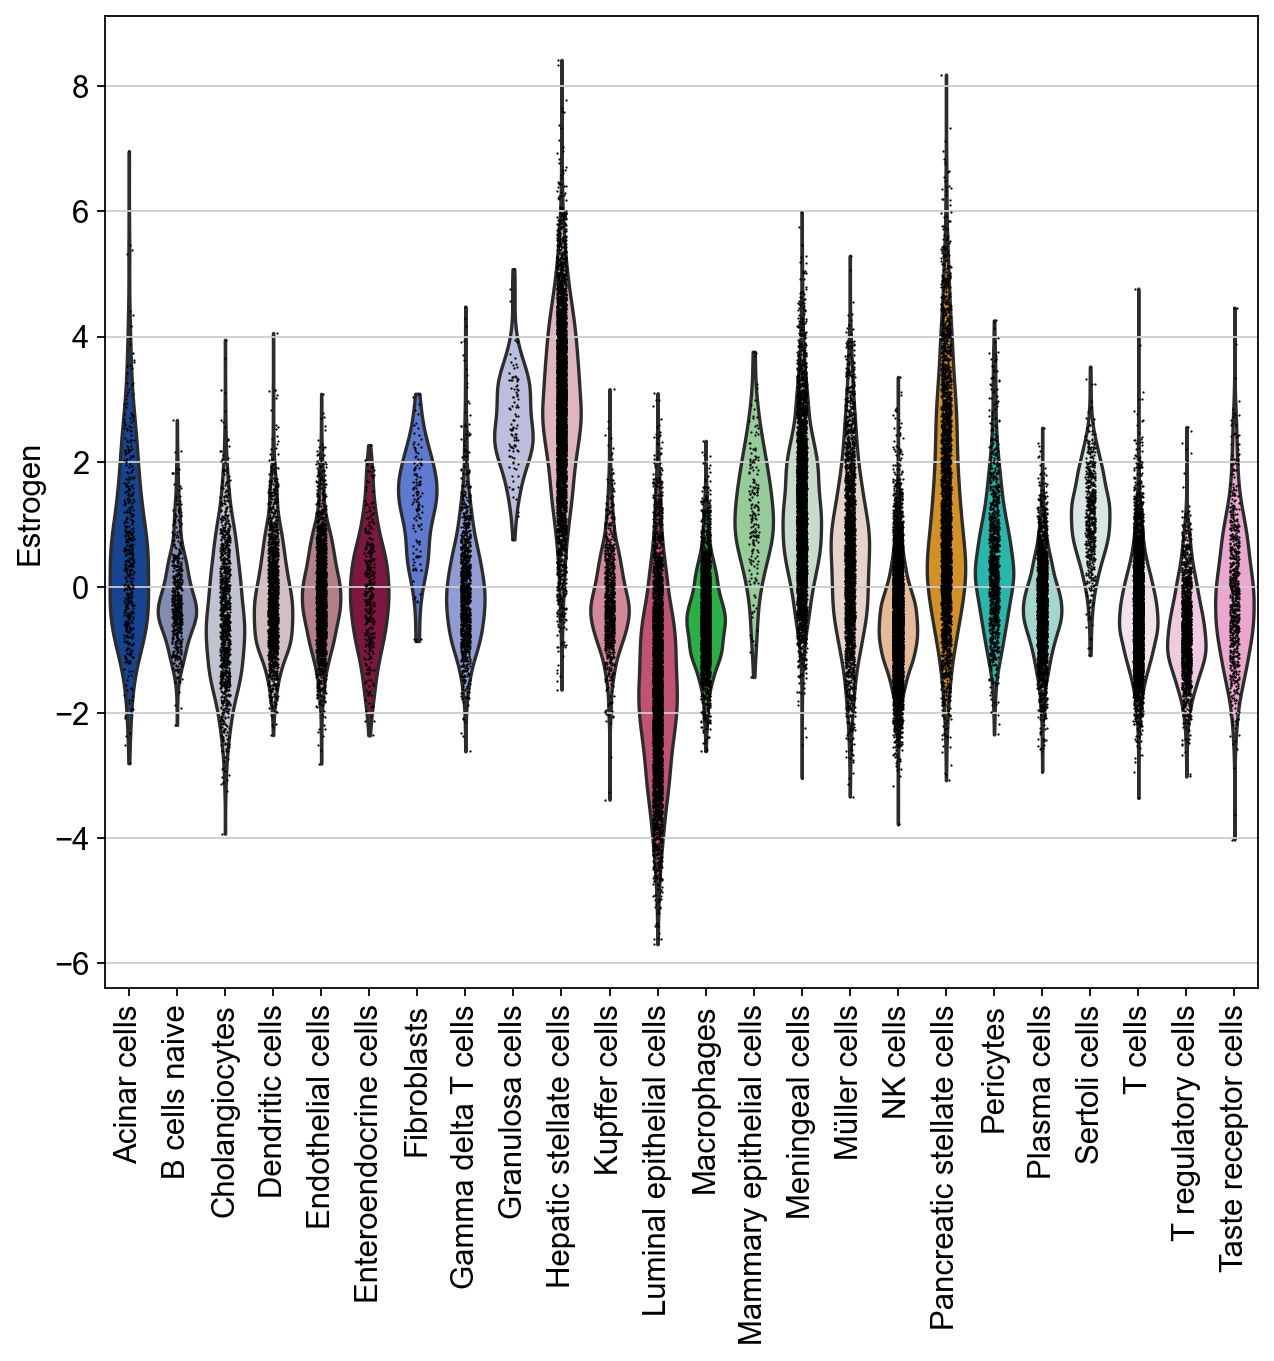

In [19]:
# Finally, we can check individual pathways by plotting their distributions:

sc.pl.violin(acts, keys=['Estrogen'], groupby='cell_type', rotation=90)
